In [2]:
from src.data import FTRC_Data
from src.modeling import *
import json
from pathlib import Path

import seaborn as sns

from src.analysis import *
from src.data import FTRC_Data

import warnings
warnings.filterwarnings('ignore')

import shap



In [3]:
# Training Set with all cell data used in base models (100%SOC)

# Import battery failure data bank
data = FTRC_Data()

# Remove all SOCs except 100%
data.df = data.df[data.df["Pre-Test-State-of-Charge-%"] == 100]

# Remove non-commercial cells, 'test' cells, and cells with less than 10 measurements from the data set
cells_to_remove = [
    'Soteria 18650 (AL)',
    'Soteria 18650 (ALCU)',
    'Soteria 18650 (CU)',
    'Soteria 18650 (DW)',
    'Soteria 18650 (ALDW)',
    'Soteria 18650 (ALCUDW)',
    'Soteria 18650 (Control)',
    'Saft D-Cell-VES16',
    'MOLiCEL 18650-J',
    'MOLiCEL 18650-M35A',
    'MOLiCEL 18650-P28A', #remove if want in training set
    'MOLiCEL 18650-Test Cell',
    'MOLiCEL 18650-Test Cell (DW-Gold)',
    'MOLiCEL 18650-Test Cell (DW-Silver)',
    'LG 18650-HG2',
    'LG 18650-M36', #remove if want in training set 
    'LG 18650-Test Cell (NBV-220)',
    'LG 18650-Test Cell (NBV-250)',
    'Panasonic 18650-BE',
    'Samsung 18650-26J',
    'Samsung 18650-30Q',
    'Sony 18650-VTC6',
    ]
for cell in cells_to_remove:
    data.remove(cell)

df = data.df

df.loc[:, "Distribution"] = "Actual"

# Isolate Training Set 
data_train = data.df.copy()


# No Test Set Needed
# # Isolate Test Set with 100% M36 and P28A
# data = FTRC_Data()

# # isolate to four cells with SOC data
# data_test = data.df.copy()
# cells_SOC = data_test[data_test['Pre-Test-State-of-Charge-%']!=100]['Cell-Description'].value_counts().index.to_list()
# data_test = data_test[data_test['Cell-Description'].isin(cells_SOC)]


# # remove LG 18650-MJ1 (Korean) all cells and LG 21700-M50 (BV) 100% SOC
# drop_index = data_test.index[(data_test['Cell-Description']=='LG 18650-MJ1 (Korean)')]
# data_test = data_test.drop(drop_index)

# drop_index = data_test.index[(data_test['Cell-Description']=='LG 21700-M50 (BV)') & (data_test['Pre-Test-State-of-Charge-%']==100)]
# data_test = data_test.drop(drop_index)

# cells_SOC.remove('LG 18650-MJ1 (Korean)')


# # test = LG 18650-MJ1 (Korean), LG 21700-M50 (BV), MOLiCEL 18650-P28A, LG 18650-M36

# # data_test

In [4]:
# Defining features to keep
features_metadata = [
    'Cell-Description',
    'Manufacturer',
    'Geometry',
    'Cell-Capacity-Ah',
    'Trigger-Mechanism',
    'Cell-Failure-Mechanism',
    'BV Actuated',
    'Pre-Test-State-of-Charge-%'
]
features_ejected_mass = [
    'Total-Mass-Ejected-g', 'Total Ejected Mass Fraction [g/g]', # overall mass loss
    'Post-Test-Mass-Unrecovered-g', 'Unrecovered Mass Fraction [g/g]', # unrecovered mass
    'Pre-Test-Cell-Mass-g', 'Post-Test-Mass-Cell-Body-g', 'Body Mass Remaining Fraction [g/g]', # body mass loss
    'Positive-Mass-Ejected-g', 'Positive Ejected Mass Fraction [g/g]', # positive end mass loss
    'Negative-Mass-Ejected-g', 'Negative Ejected Mass Fraction [g/g]', # negative end mass loss
]
# Target variables
targets = [
    'Total Heat Output [kJ/A*h]',
    'Cell Body Heat Output [kJ/A*h]',
    'Positive Heat Output [kJ/A*h]',
    'Negative Heat Output [kJ/A*h]',
]

# Lots of extra columns in the data set, only keep the defined subset for modeling
data_train_t= data_train[features_metadata + features_ejected_mass + targets]

# One hot encode
cell_type = 'Sanyo 18650-A'
data_train = Split(data_train_t, 'cell_type_split', cell_type_test=cell_type) 
one_hot_columns=['Cell-Description', 'Manufacturer' , 'Geometry', 'Trigger-Mechanism', 'Cell-Failure-Mechanism']
data_train.one_hot_encode(one_hot_columns)



In [5]:
# create model with all data
y_columns = [
                'Total Heat Output [kJ/A*h]', 
                'Cell Body Heat Output [kJ/A*h]',
                'Positive Heat Output [kJ/A*h]',
                'Negative Heat Output [kJ/A*h]',
                ]


svm = make_pipeline(StandardScaler(), RegressorChain(SVR(C=1, epsilon=0.1, kernel='linear'), order=[1,3,2,0]))

x = data_train.data.drop(y_columns, axis=1).copy()
y = data_train.data.loc[:,y_columns]

x_train = x
y_train = y

svm.fit(x_train, y_train)

explainer = shap.KernelExplainer(model=svm.predict, data=x_train)

# shap_values = explainer.shap_values(X=x_train) #, takes a while to run, nsamples=100 to speed up/test


Using 139 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


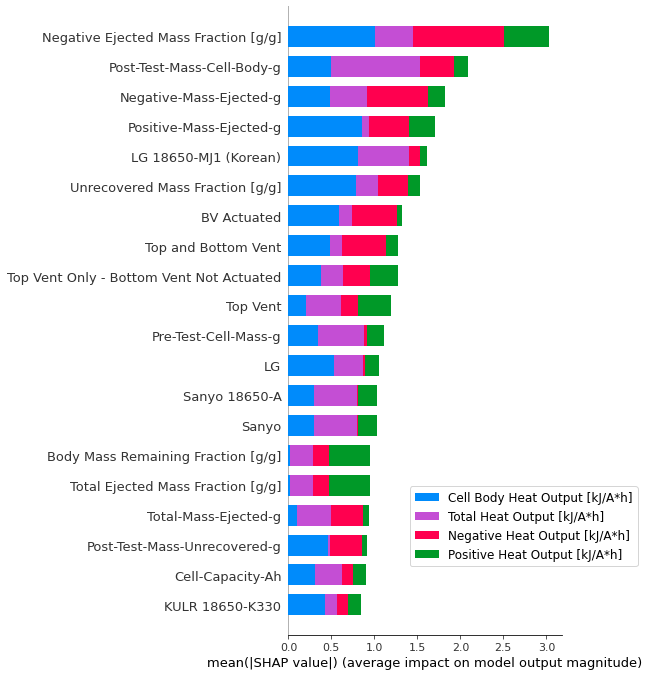

In [24]:
# Summary Plot
targets = ["Total Heat Output [kJ/A*h]", "Positive Heat Output [kJ/A*h]",
           "Cell Body Heat Output [kJ/A*h]", "Negative Heat Output [kJ/A*h]"]
shap.summary_plot(shap_values, x_train, class_names=targets, show=False)
plt.legend(loc='lower right',bbox_to_anchor=(1.3, 0.1), fontsize=12)
plt.savefig('Shap-summary.png', dpi=200, bbox_inches='tight')

0


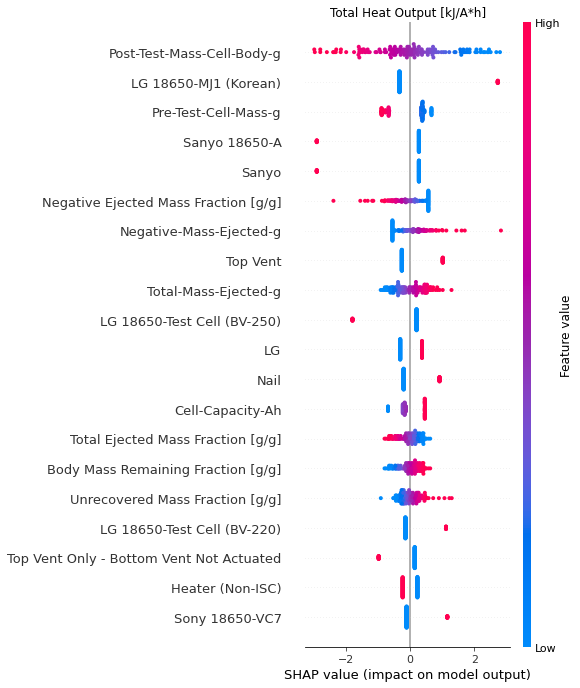

1


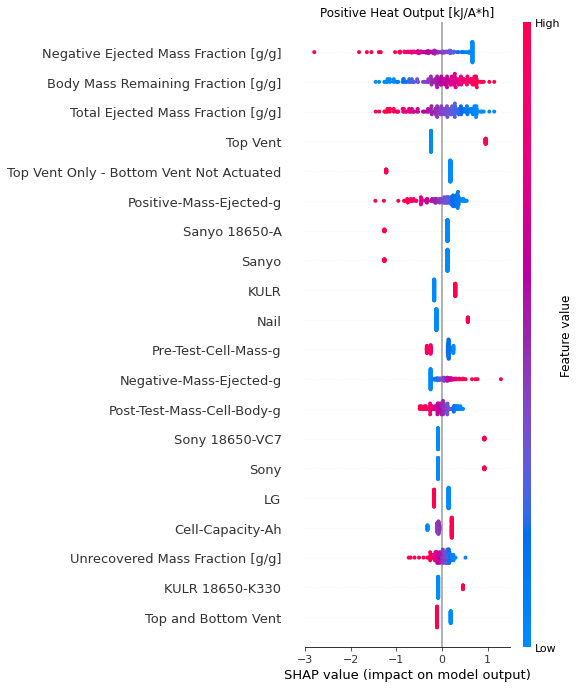

2


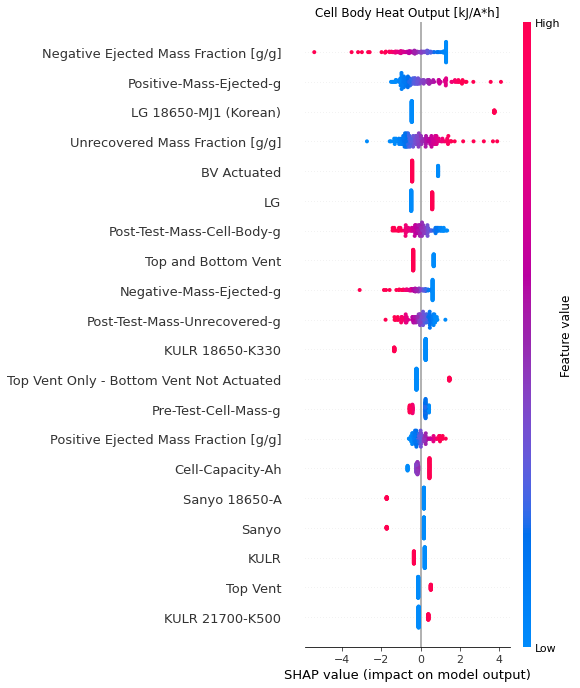

3


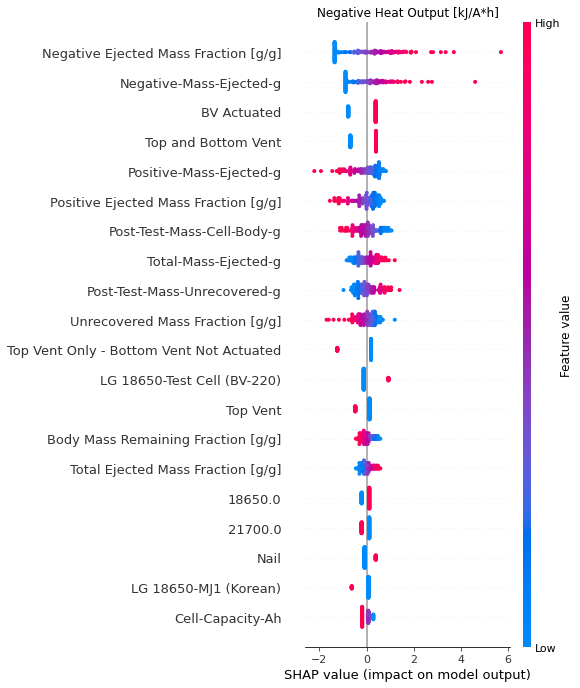

In [23]:
# Individual Swarm Plots

title = ' ShapIndividual.png'
for i in range(4):
    print(i)
    shap.summary_plot(shap_values[i], x_train, show=False)
    plt.title(targets[i])
    plt.savefig(str(i)+title, dpi=200)
    plt.show()
